<a href="https://colab.research.google.com/github/Haebuk/Python_Machine_Learning/blob/master/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyOD -q
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data, evaluate_print
from pyod.utils.example import visualize

     |████████████████████████████████| 112kB 14.4MB/s 


In [ ]:
X_train, y_train, X_test, y_test = generate_data(
    n_train=10000, n_test=500, n_features=2
)

/usr/local/lib/python3.7/dist-packages/pyod/utils/data.py:189: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


In [ ]:
# detector 초기화
IF = IForest()
abod = ABOD()
ae = AutoEncoder(hidden_neurons=[2,1,1,2], epochs=40)
knn = KNN()
IF.fit(X_train)
abod.fit(X_train)
ae.fit(X_train)
knn.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

score ROC:1.0, precision @ rank n:1.0


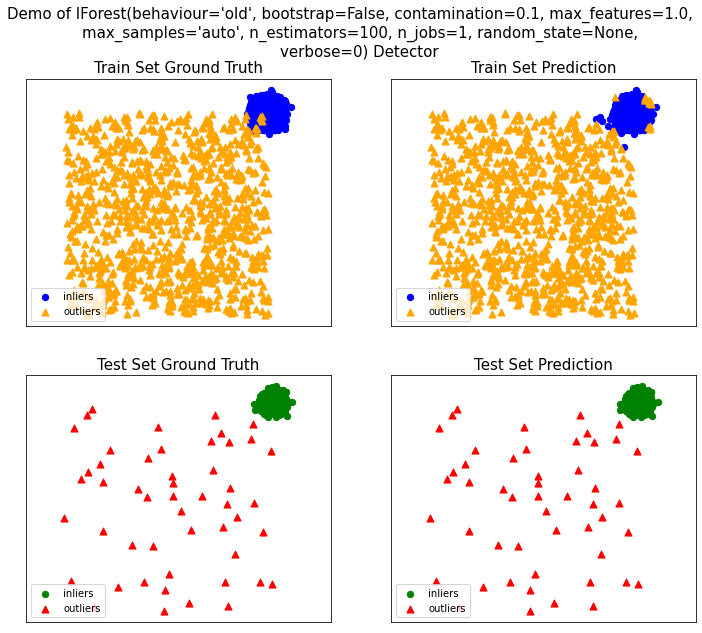

score ROC:0.999, precision @ rank n:0.96


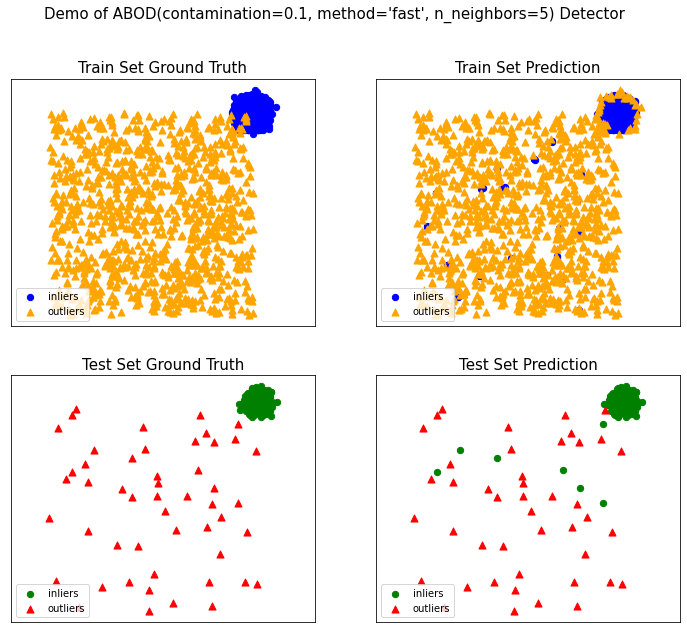

score ROC:1.0, precision @ rank n:0.98


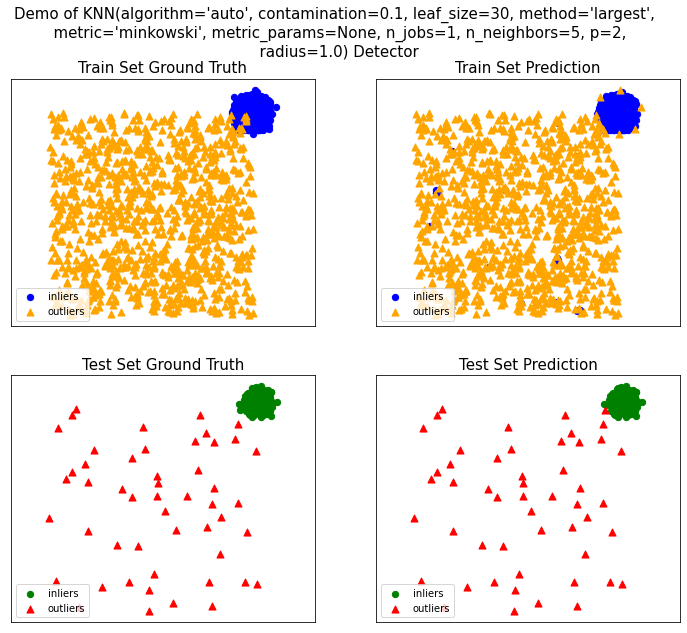

score ROC:0.992, precision @ rank n:0.96


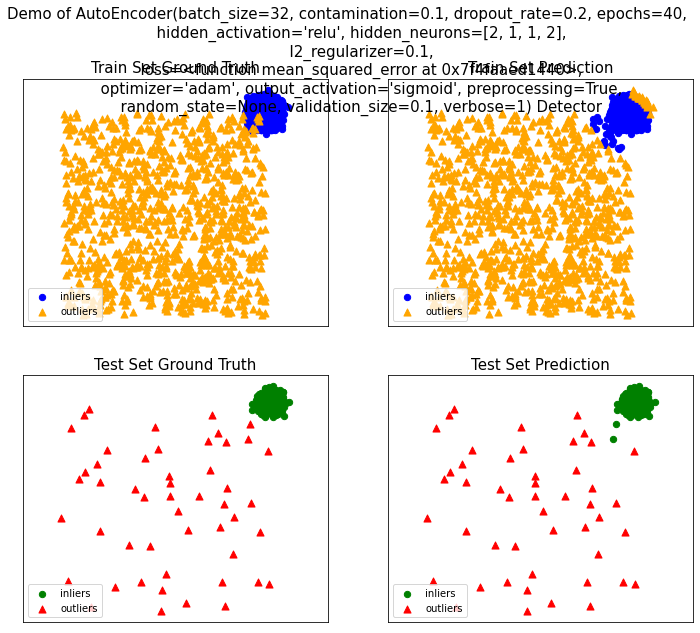

In [ ]:
detectors = [IF, abod, knn, ae]
for d in detectors:
    # binary labels
    y_train_pred = d.predict(X_train)
    y_test_pred = d.predict(X_test)

    # raw outlier scores
    y_test_scores = d.decision_function(X_test)

    # outlier probability
    #y_test_proba = display.predict_proba(X_test)

    # performance evaluation
    evaluate_print('score', y_test, y_test_scores)

    # prediction visualization
    visualize(d, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)

In [ ]:
kaggle datasets download -d mlg-ulb/creditcardfraud
{"username":"haebuk","key":"7be7e6f6590d2e4e2b37c50726ba7138"}


SyntaxError: ignored

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'haebuk'
os.environ['KAGGLE_KEY'] = '7be7e6f6590d2e4e2b37c50726ba7138'
!kaggle datasets download -d mlg-ulb/creditcardfraud

 86% 57.0M/66.0M [00:01<00:00, 23.4MB/s]
100% 66.0M/66.0M [00:01<00:00, 38.1MB/s]


In [ ]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,
                                                        random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1-score: {f1:.4f}, roc-auc: {roc_auc:.4f}')

In [ ]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    get_clf_eval(tgt_test, pred)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

오차 행렬
[[85282    13]
 [   64    84]]
정확도: 0.9991, 정밀도: 0.8660, 재현율: 0.5676, f1-score: 0.6857, roc-auc: 0.7837


In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, f1-score: 0.8421, roc-auc: 0.8783


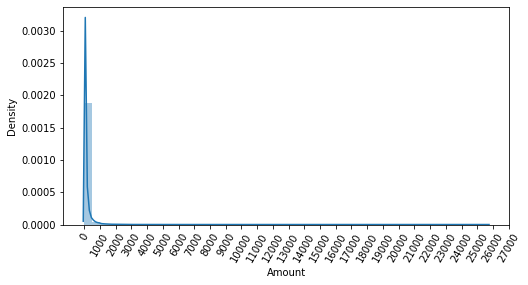

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('Logistic Regression')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('LightGBM')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

Logistic Regression
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, f1-score: 0.7149, roc-auc: 0.8006
LightGBM
오차 행렬
[[85148   147]
 [  147     1]]
정확도: 0.9966, 정밀도: 0.0068, 재현율: 0.0068, f1-score: 0.0068, roc-auc: 0.5025


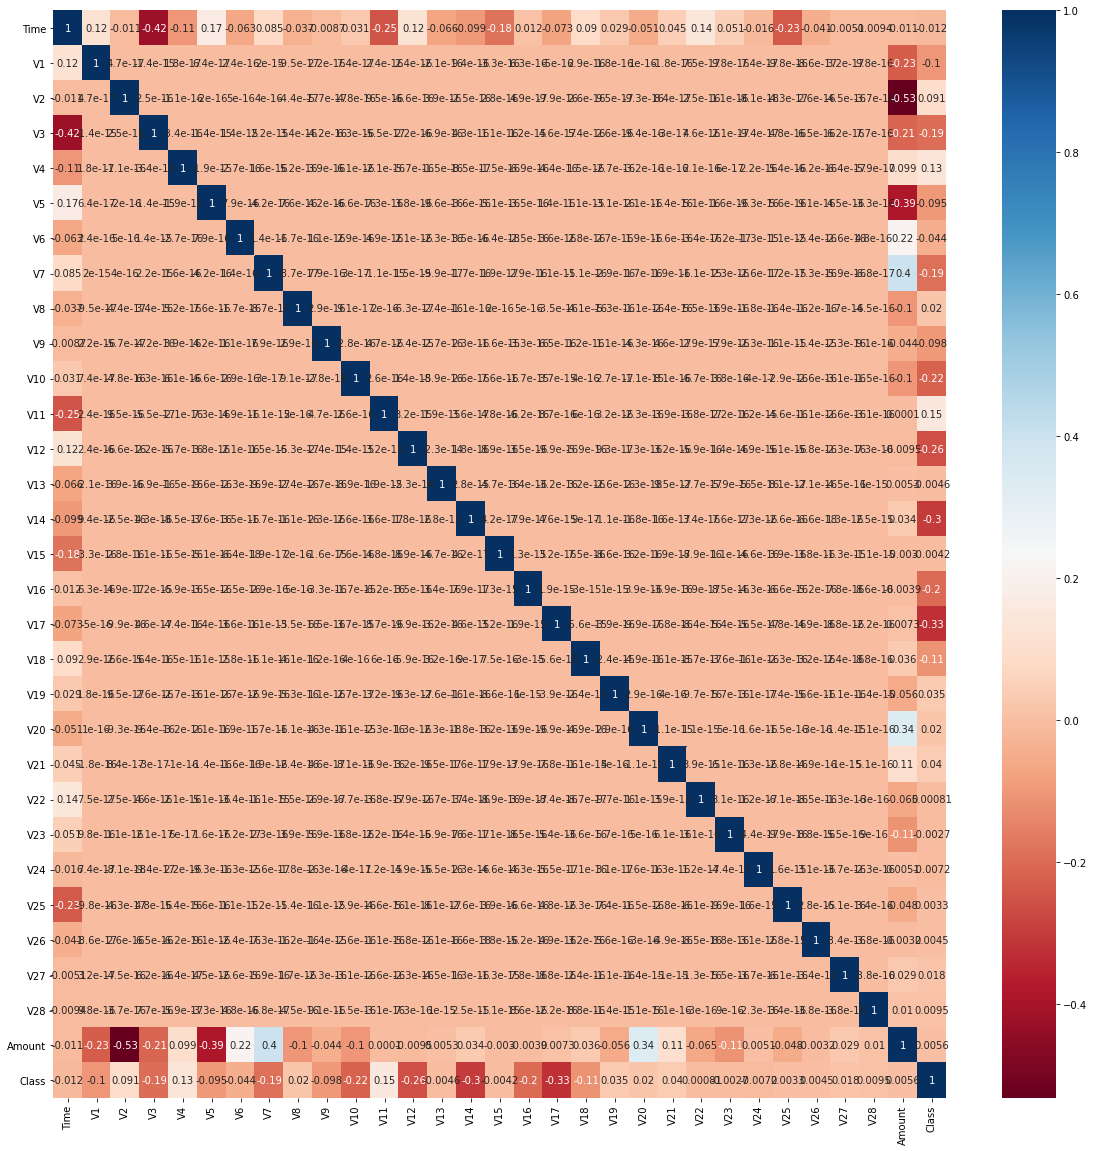

In [ ]:
plt.figure(figsize=(20, 20))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu', annot=True)
plt.show()

In [ ]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 인덱스:', outlier_index)

이상치 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    outlier_index = get_outlier(df_copy, 'V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('Logistic Regression')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('LightGBM')
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

Logistic Regression
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, f1-score: 0.7597, roc-auc: 0.8355
LightGBM
오차 행렬
[[85179   116]
 [  117    29]]
정확도: 0.9973, 정밀도: 0.2000, 재현율: 0.1986, f1-score: 0.1993, roc-auc: 0.5986


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습 피처/ 레이블 데이터 셋:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습 피처/ 레이블 데이터 셋:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습 피처/ 레이블 데이터 셋: (199362, 29) (199362,)
SMOTE 적용 후 학습 피처/ 레이블 데이터 셋: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 1    199020
0    199020
dtype: int64


In [ ]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, f1-score: 0.1023, roc-auc: 0.9485


In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493, f1-score: 0.8889, roc-auc: 0.9246


In [ ]:
IF = IForest()
get_model_train_eval(IF, X_train, X_test, y_train, y_test)

오차 행렬
[[76759  8536]
 [   15   131]]
정확도: 0.8999, 정밀도: 0.0151, 재현율: 0.8973, f1-score: 0.0297, roc-auc: 0.8986


In [ ]:
IF = IForest()
get_model_train_eval(IF, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[84635   660]
 [  114    32]]
정확도: 0.9909, 정밀도: 0.0462, 재현율: 0.2192, f1-score: 0.0764, roc-auc: 0.6057


In [ ]:
knn = KNN()
get_model_train_eval(knn, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[68075 17220]
 [   44   102]]
정확도: 0.7979, 정밀도: 0.0059, 재현율: 0.6986, f1-score: 0.0117, roc-auc: 0.7484


In [ ]:
abod = ABOD()
get_model_train_eval(abod, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[85295     0]
 [  146     0]]
정확도: 0.9983, 정밀도: 0.0000, 재현율: 0.0000, f1-score: 0.0000, roc-auc: 0.5000


In [ ]:
ae = AutoEncoder(hidden_neurons=[30,15,15,30], epochs=40)
get_model_train_eval(ae, X_train_over, X_test, y_train_over, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 29)                870       
_________________________________________________________________
dropout (Dropout)            (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dropout_1 (Dropout)          (None, 29)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                900       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                4